In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs

In [2]:
from mejiro.lenses import lens_util

detectable_lenses = lens_util.get_detectable_lenses(config.machine.pipeline_dir, limit=10, with_subhalos=True)
print(f'Number of detectable lenses: {len(detectable_lenses)}')

best_snr = [l for l in detectable_lenses if l.snr > 50]
print(f'Number of high SNR lenses: {len(best_snr)}')

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 15.66it/s]

Number of detectable lenses: 10
Number of high SNR lenses: 10


In [10]:
sample_lens = np.random.choice(detectable_lenses)

num_pix = 91
side = 10.01

# generate synthetic image (surface brightness)
sb = sample_lens.get_array(num_pix=num_pix, side=side, band='F129')

In [11]:
total_kappa = sample_lens.get_total_kappa(num_pix=num_pix, side=side)
macrolens_kappa = sample_lens.get_macrolens_kappa(num_pix=num_pix, side=side)
subhalo_kappa = sample_lens.get_subhalo_kappa(num_pix=num_pix, side=side)

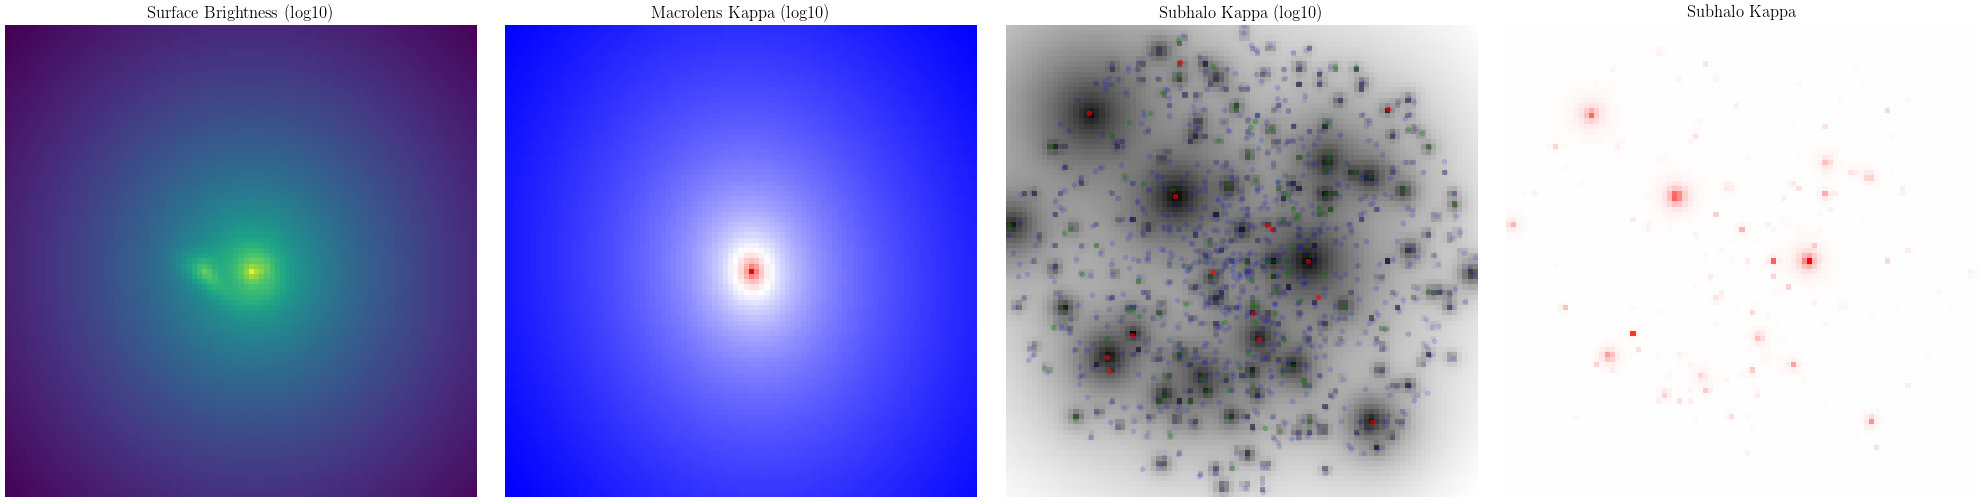

In [28]:
f, ax = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=True)
ax[0].imshow(sb, norm=colors.LogNorm())
ax[1].imshow(macrolens_kappa, cmap='bwr', norm=colors.LogNorm())
ax[2].imshow(np.log10(subhalo_kappa), cmap='binary')
ax[3].imshow(subhalo_kappa, cmap='bwr', vmin=-np.max(subhalo_kappa), vmax=np.max(subhalo_kappa))

ax[0].set_title('Surface Brightness (log10)')
ax[1].set_title('Macrolens Kappa (log10)')
ax[2].set_title('Subhalo Kappa (log10)')
ax[3].set_title('Subhalo Kappa')

# overplot subhalos
coords = lens_util.get_coords(num_pix=91, delta_pix=0.11)
for halo in sample_lens.realization.halos:
    if halo.mass > 1e8:
        ax[2].plot(*coords.map_coord2pix(halo.x, halo.y), marker='.', color='r', alpha=0.5)
    elif halo.mass > 1e7:
        ax[2].plot(*coords.map_coord2pix(halo.x, halo.y), marker='.', color='g', alpha=0.25)
    else:
        ax[2].plot(*coords.map_coord2pix(halo.x, halo.y), marker='.', color='b', alpha=0.1)

for a in ax: a.axis('off')
# plt.savefig(os.path.join(figure_dir, 'f_sub_sample.png'))
plt.show()

In [13]:
einstein_radius = sample_lens.get_einstein_radius()
print(f'Einstein radius: {einstein_radius:.2f} arcsec')

r_in = (einstein_radius - 0.2) / 0.11  # units of pixels
r_out = (einstein_radius + 0.2) / 0.11  # units of pixels

Einstein radius: 0.54 arcsec


In [14]:
def annular_mask(dimx, dimy, center, r_in, r_out):
    Y, X = np.ogrid[:dimx, :dimy]
    distance_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    return (r_in <= distance_from_center) & \
    (distance_from_center <= r_out)

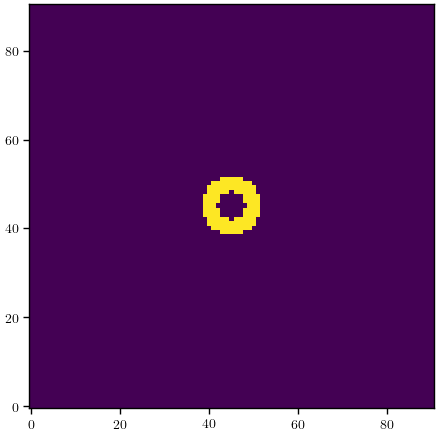

In [15]:
mask = annular_mask(*sb.shape, (sb.shape[0]//2, sb.shape[1]//2), r_in, r_out)

plt.imshow(mask)
plt.show()

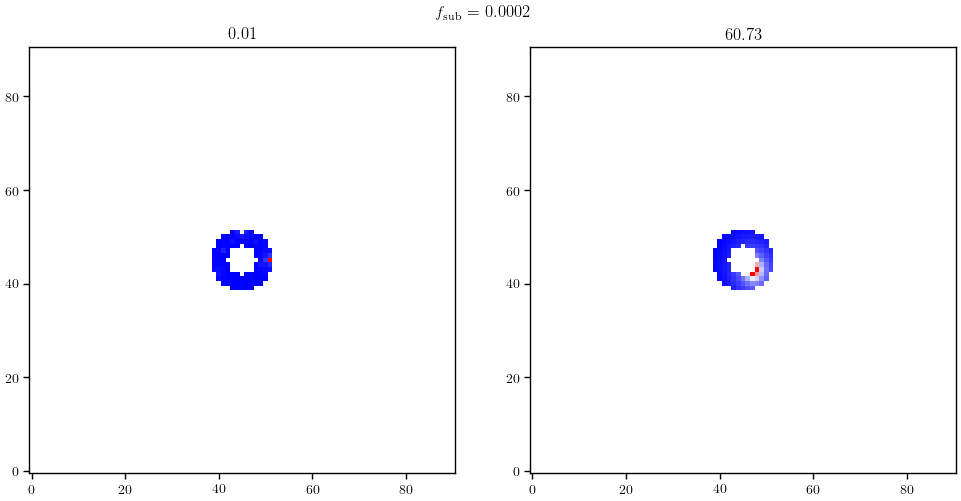

In [17]:
masked_kappa_subhalos = np.ma.masked_array(subhalo_kappa, mask=~mask)
masked_kappa_macro = np.ma.masked_array(macrolens_kappa, mask=~mask)

numerator = masked_kappa_subhalos.compressed().sum()
denominator = masked_kappa_macro.compressed().sum()

f, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
ax[0].imshow(masked_kappa_subhalos, cmap='bwr')
ax[1].imshow(masked_kappa_macro, cmap='bwr')
ax[0].set_title(f'{numerator:.2f}')
ax[1].set_title(f'{denominator:.2f}')

f_sub = numerator / denominator
plt.suptitle(r'$f_{\mathrm{sub}}$ = ' + f'{f_sub:.4f}')

plt.show()